In [33]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
from sklearn.cluster import DBSCAN, KMeans, OPTICS, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import davies_bouldin_score, make_scorer
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
focos = pd.read_csv("dados/Focos.csv")

In [3]:
def datahora_isoformat(s:str):
    [date, time] = s.split(" ")
    date = date.replace("/", "-")
    return f"{date}T{time}"

In [4]:
focos["datahora"] = focos["datahora"].apply(datahora_isoformat)

Rode para reverter datahora para formato ISO

In [5]:
focos_datahora_str = focos["datahora"]

In [6]:
focos["datahora"] = focos_datahora_str

In [7]:
focos["datahora"] = focos["datahora"].apply(lambda x: datetime.fromisoformat(x).timestamp() * 1000)

array([[<Axes: title={'center': 'datahora'}>,
        <Axes: title={'center': 'diasemchuva'}>,
        <Axes: title={'center': 'precipitacao'}>],
       [<Axes: title={'center': 'riscofogo'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'frp'}>, <Axes: >, <Axes: >]],
      dtype=object)

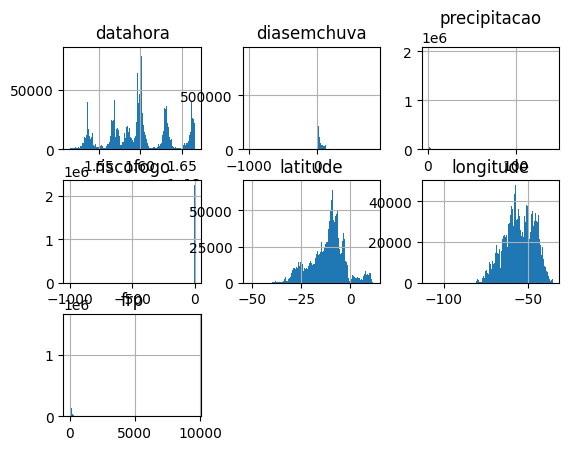

In [8]:
focos.hist(bins=200)

Transformar focos em dados para PCA

In [9]:
focos_pca = focos.copy()
focos_pca = focos_pca.drop(columns=["satelite", "pais", "estado", "municipio", "bioma", "datahora"])
focos_pca = focos_pca.dropna()
scaler = StandardScaler()
scaler.set_output(transform="pandas")
focos_pca = scaler.fit_transform(focos_pca)

In [10]:
pca = PCA(n_components=2)
pca.fit(focos_pca)


PCA(n_components=2)

In [11]:
focos_pca_t= pca.transform(focos_pca)
pca.feature_names_in_
pca.explained_variance_ratio_

array([0.19345832, 0.17392996])

<Axes: xlabel='0', ylabel='1'>

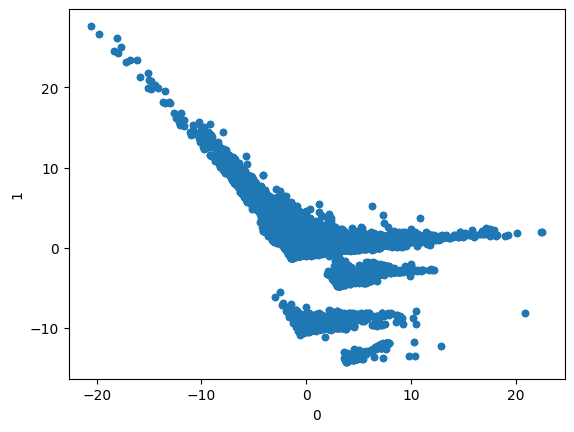

In [12]:
focos_pca_t = pd.DataFrame(focos_pca_t)
focos_pca_t.plot(0, 1, kind="scatter")

<Axes: xlabel='riscofogo', ylabel='frp'>

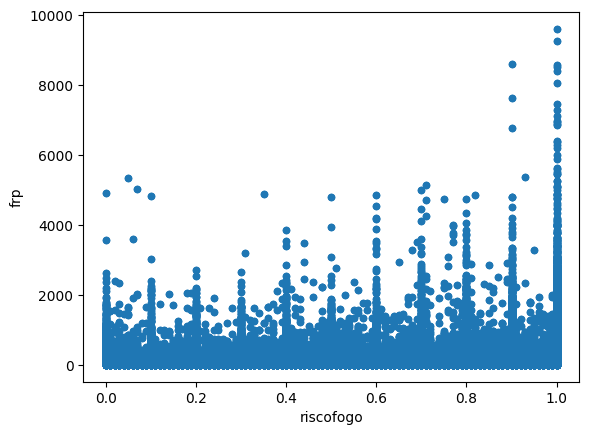

In [13]:
plotting = focos.dropna()
plotting.loc[:, "riscofogo"] = plotting["riscofogo"].apply(lambda x: float('nan') if (np.isnan(x) or x < 0) else x)
plotting = plotting.dropna()
plotting.plot("riscofogo", "frp", kind='scatter')

In [14]:
plotting['frp'].describe()

count    1.779374e+06
mean     6.318227e+01
std      1.407506e+02
min      0.000000e+00
25%      1.530000e+01
50%      2.870000e+01
75%      6.010000e+01
max      9.612200e+03
Name: frp, dtype: float64

<Axes: >

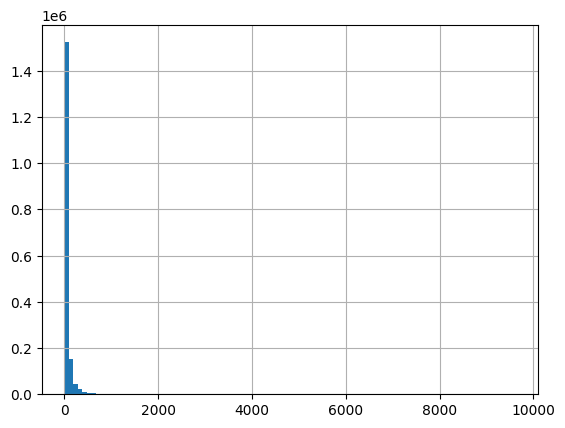

In [15]:
plotting["frp"].hist(bins=100)

<Axes: xlabel='pca0', ylabel='pca1'>

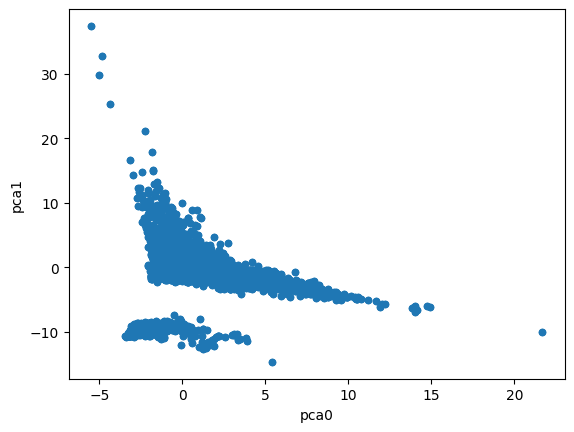

In [16]:
dbscan = DBSCAN(algorithm='kd_tree')
jan2018 = datetime(2018, 1, 1).timestamp() * 1000
jan2019 = datetime(2019, 1, 1).timestamp() * 1000
focos_2018 = focos[(focos["datahora"] >= jan2018) & (focos['datahora'] < jan2019)]
focos_2018 = focos_2018.drop(columns=["satelite", "pais", "estado", "municipio", "bioma", "datahora"])
pca2018 = PCA(n_components=2)
pca2018.set_output(transform='pandas')
focos_pca_2018 = pca2018.fit_transform(scaler.fit_transform(focos_2018))
focos_pca_2018.plot(0, 1, kind="scatter")

In [17]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=3, n_init='auto')
focos_2018_labels = minibatch_kmeans.fit_predict(focos_2018)

In [18]:
# optics = OPTICS(max_eps=5, min_cluster_size=20000, n_jobs=8)
# s = StandardScaler()
# focos_2018_labels = optics.fit_predict(s.fit_transform(focos_2018))
# np.savetxt('focos_2018_labels.txt', focos_2018_labels)

In [19]:
np_focos_pca_2018 = focos_pca_2018.to_numpy()

In [20]:
def plot_cluster(np_cluster: np.array, labels: np.array):
    _labels = labels.reshape(-1, 1)
    for k in np.unique(labels):
        e = np_cluster[_labels[:, -1] == k]
        plt.scatter(e[:, 0], e[:, 1], label=f"Group {k}")
    plt.show()

In [46]:
class0_2018 = focos_2018[(focos_2018_labels == 0) & (focos_2018['riscofogo'] >= 0)]
class1_2018 = focos_2018[(focos_2018_labels == 1) & (focos_2018['riscofogo'] >= 0)]
class2_2018 = focos_2018[(focos_2018_labels == 2) & (focos_2018['riscofogo'] >= 0)]

In [51]:
class0_2018.describe()

,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
count,12566.000000,12566.000000,12566.000000,12566.000000,12566.000000,12566.000000
mean,-123.224415,0.503661,0.733344,-8.634916,-51.805515,342.548353
std,348.853723,2.003403,0.330559,5.376189,8.139962,339.355726
min,-999.000000,0.000000,0.000000,-31.122000,-73.227000,4.000000
25%,2.000000,0.000000,0.500000,-11.310000,-58.202250,206.200000
50%,6.000000,0.000000,0.900000,-8.548000,-50.935000,263.700000
75%,15.000000,0.100000,1.000000,-4.524750,-44.884500,387.300000
max,120.000000,49.200000,1.000000,4.022000,-34.843000,7303.400000


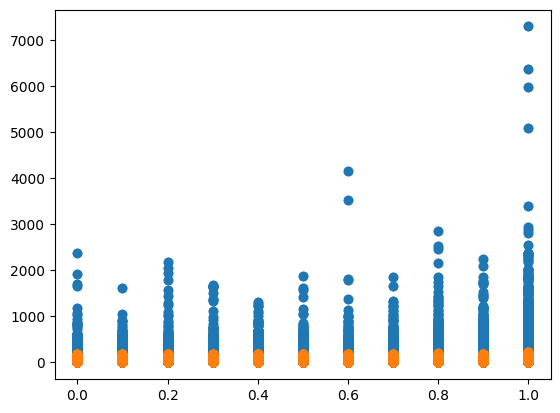

In [52]:
plt.scatter(class0_2018["riscofogo"], class0_2018["frp"])
plt.scatter(class1_2018["riscofogo"], class1_2018["frp"])
# plt.scatter(class2_2018["riscofogo"], class2_2018["frp"])
plt.show()

## Grid Search: MiniBatchKMeans

In [40]:
def calc_dbi(estimator, x):
    y = estimator.fit_predict(x)
    # O GridSearch do scikit_learn sempre pega o modelo com maior score
    # mas o melhor modelo usando davies_boulding_score é aquele com menor score
    # então, invertemos o valor do score para fazer com que o menor score tenha valores mais altos
    # fazendo o GridSearch escolher ele.
    return 1/davies_bouldin_score(x, y)
minibatch_kmeans_params = {
    "n_clusters": [2, 3, 4],
    "init": ["k-means++", "random"],
    "n_init": ["auto"]
}
make_scorer(calc_dbi, greater_is_better=False)
minik = MiniBatchKMeans()
grids = GridSearchCV(minik, minibatch_kmeans_params, scoring= calc_dbi)
best = grids.fit(focos_2018)

In [42]:
best.best_params_

{'init': 'k-means++', 'n_clusters': 2, 'n_init': 'auto'}

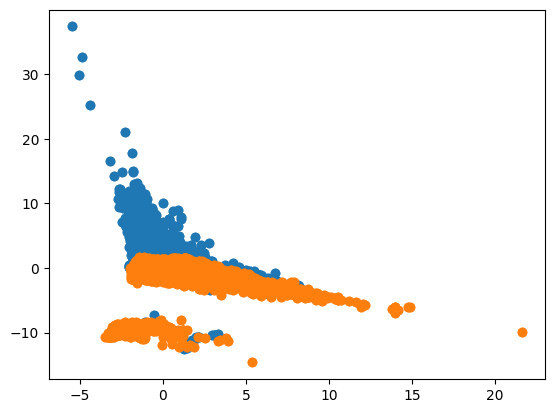

In [45]:
minibatch_kmeans = best.best_estimator_
focos_2018_labels = minibatch_kmeans.fit_predict(focos_2018)
plot_cluster(np_focos_pca_2018, focos_2018_labels)

Estatísticas de classe

In [56]:
def describe_labels(labels: np.array):
    unique = np.unique(labels)
    total = len(labels)
    for l in unique:
        class_size = len(labels[labels == l])
        print(f"Classe {l}: {class_size} elementos. ({(class_size/total) * 100}% do total)")
    print(f"Total: {total} elementos.")

In [57]:
describe_labels(focos_2018_labels)

Classe 0: 12612 elementos. (4.742102136427556% do total)
Classe 1: 253346 elementos. (95.25789786357244% do total)
Total: 265958 elementos.
